# Steps to solve Emergency vehicle classification problem

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Compiling the model (defining loss function, optimizer)</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>
<ol>8. Hyperparameter Tuning</ol>

## 1. Loading the dataset

In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip folder where csv file of labes and folder containing all images is stored.

Folder contains csv file of labels and one folder contains all images.



In [ ]:
!unzip /content/drive/MyDrive/Pytorch/Datasets/emergency_vehicle_images.zip

Archive:  /content/drive/MyDrive/Pytorch/Datasets/emergency_vehicle_images.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  i

Read csv file of labels. It contains image name and class.

In [ ]:
# reading the csv file
data = pd.read_csv('Dataset/emergency_classification.csv')

In [ ]:
# creating a random seed
seed = 42

In [ ]:
# looking at first five rows of the data
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


Normalize all images and store them in numpy array.

Store values in target (column in above dataframe) into another array y.

In [ ]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:

    # loading the image using its name
    img = plt.imread('Dataset/images/' + img_name)

    # normalizing the pixel values
    img = img / 255

    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

In [ ]:
# shape of images
X.shape

(2352, 224, 224, 3)

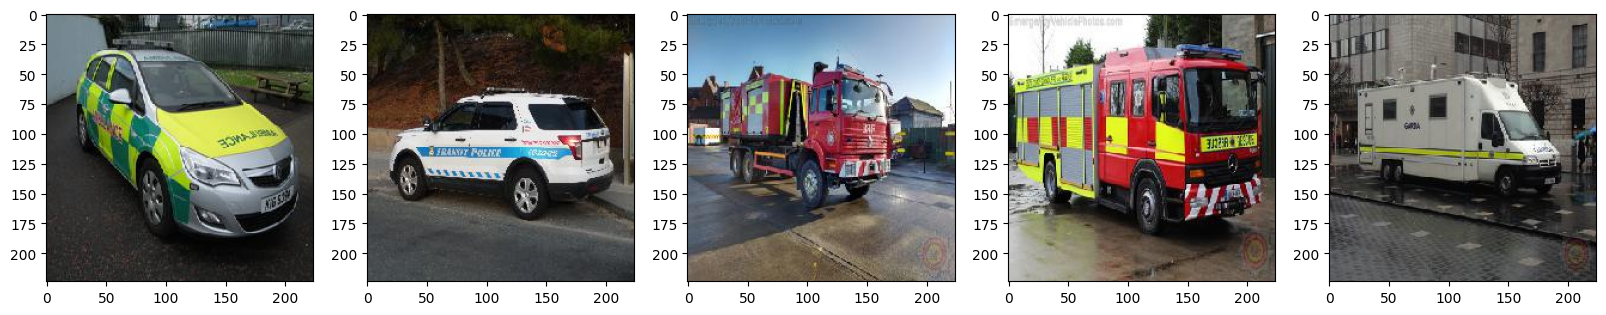

In [ ]:
# glance at the images
fig, axes = plt.subplots(ncols=5,figsize=(20,10))
for i in range(5):
  axes[i].imshow(X[i])

## 2. Pre-processing the data

In [ ]:
# reshape each image into 224*224*3 1D array ie one row of dataframe.
X = X.reshape(-1, 224*224*3).astype('float32')
X.shape

(2352, 150528)

## 3. Creating training and validation set

In [ ]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed, stratify=y)

In [ ]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 150528), (1646,)), ((706, 150528), (706,)))

Convert all train test numpy arrays into torch.tensors.

In [ ]:
# importing torch library
import torch

In [ ]:
# converting training and validation set to PyTorch tensor

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

## 4. Defining the model architecture

In [ ]:
# importing functions from torch for defining the model architecture
import torch.nn as nn
from torch.nn import Linear, Sigmoid, Sequential

In [ ]:
# defining the architecture of the model

class Net(nn.Module):                            # Class Net have same properties as nn module in pytorch
    def __init__(self):                          # To initilize class Net
        super(Net, self).__init__()
                                                 # Define layers of neural n/w
        self.linear_layers = Sequential(
            Linear(X_train.shape[1],100),        # Input shape ie equal to no of columns and number of neurons in layer(100)
            Sigmoid(),
            Linear(100, 1),
            Sigmoid())

    # Defining the forward pass
    def forward(self, x):                       # class for forward pass
        x = self.linear_layers(x)
        return x

## 5. Compiling the model (defining loss function, optimizer)

In [ ]:
from torch.nn import BCELoss
from torch.optim import Adam

In [ ]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()               # call Net class defined above

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# defining the loss function
criterion = BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=150528, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## 6. Training the model

In [ ]:
# batch size of the model
batch_size = 64

for epoch in tqdm(range(100)):            # tqdm is used to keep track of learning process
    # setting initial loss as 0
    train_loss = 0.0

    # to randomly pick the images without replacement in batches
    permutation = torch.randperm(X_train.size()[0])      # Array storing random indexes of train data

    # to keep track of training loss for each epoch
    training_loss = []

    # for loop for training on batches
    for i in range(0,X_train.size()[0], batch_size):

        # defining the training phase
        model.train()

        # taking the indices from randomly generated values
        indices = permutation[i:i+batch_size]               # store indices of  batch from array permutation

        # getting the images and labels for a batch
        batch_x, batch_y = X_train[indices], y_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        # clearing all the accumulated gradients
        optimizer.zero_grad()                                        # calculates fresh gradient in each batch for same epoch

        # mini batch computation
        outputs = model(batch_x)                                           # store output of each batch

        # calculating the loss for a mini batch
        # Ensure batch_y has the same shape as outputs
        loss = criterion(outputs, batch_y.unsqueeze(1))

        # storing the loss for every mini batch of same epoch
        training_loss.append(loss.item())

        # calculating the gradients
        loss.backward()

        # updating the parameters
        optimizer.step()               # Update weights from calculated gradients using optimizer

    training_loss = np.average(training_loss)    # training loss is average of loss values in training_loss array ie loss for that epoch.
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  1%|          | 1/100 [00:00<01:30,  1.10it/s]

epoch: 	 0 	 training loss: 	 0.7799525971596057


 11%|█         | 11/100 [00:09<01:10,  1.27it/s]

epoch: 	 10 	 training loss: 	 0.685876516195444


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

epoch: 	 20 	 training loss: 	 0.6831266054740319


 31%|███       | 31/100 [00:25<00:55,  1.25it/s]

epoch: 	 30 	 training loss: 	 0.6810828263943012


 41%|████      | 41/100 [00:31<00:40,  1.47it/s]

epoch: 	 40 	 training loss: 	 0.6851072036303006


 51%|█████     | 51/100 [00:38<00:33,  1.47it/s]

epoch: 	 50 	 training loss: 	 0.6832985396568592


 61%|██████    | 61/100 [00:45<00:27,  1.42it/s]

epoch: 	 60 	 training loss: 	 0.690488514991907


 71%|███████   | 71/100 [00:53<00:22,  1.30it/s]

epoch: 	 70 	 training loss: 	 0.7074012206150935


 81%|████████  | 81/100 [01:01<00:15,  1.19it/s]

epoch: 	 80 	 training loss: 	 0.6857182268912976


 91%|█████████ | 91/100 [01:08<00:05,  1.54it/s]

epoch: 	 90 	 training loss: 	 0.6842829378751608


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


## 7. Evaluating model performance

In [ ]:
# prediction for training set
train_prediction = []            #   Store predictions
train_target = []                # store actual target values
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    # prediction phase
    model.eval()                                               # define eval function
    indices = permutation[i:i+batch_size]                      # store indices of  batch from array permutation
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()

    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

100%|██████████| 26/26 [00:00<00:00, 46.66it/s]


In [ ]:
# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))

print('training accuracy: \t', np.average(training_accuracy))

training accuracy: 	 0.5777591973244147


Do predictions on validation dataset and evaluate model.

In [ ]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda()).data.cpu()     #   Do prediction as probability of value.

    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

100%|██████████| 12/12 [00:00<00:00, 44.84it/s]


In [ ]:
# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))

print('validation accuracy: \t', np.average(valid_accuracy))

validation accuracy: 	 0.61328125


## 8. Hyperparameter Tuning

In [ ]:
# importing batchnorm and dropout layers
from torch.nn import BatchNorm1d, Dropout

In [ ]:
# defining the architecture of the model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear_layers = Sequential(
            Linear(X_train.shape[1],100),
            Sigmoid(),
            # adding batch normalization layer
            BatchNorm1d(100),
            # adding dropout layer
            Dropout(0.85, inplace=True),
            Linear(100, 100),
            Sigmoid(),
            # adding batch normalization layer
            BatchNorm1d(100),
            # adding dropout layer
            Dropout(0.85, inplace=True),
            Linear(100, 1),
            Sigmoid())

    # Defining the forward pass
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [ ]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()

# defining the optimizer
# reducing the learning rate to 1e-5
optimizer = Adam(model.parameters(), lr=1e-5)

# defining the loss function
criterion = BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=150528, out_features=100, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.85, inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.85, inplace=True)
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [ ]:
# batch size of the model
# increasing the batch size from 64 to 128
batch_size = 128

# increasing the number of epochs from 50 to 100
for epoch in tqdm(range(100)):

    # keep track of training and validation loss
    train_loss = 0.0

    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in range(0,X_train.size()[0], batch_size):

        model.train()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x)
        # remove extra dimension from outputs
        outputs = outputs.squeeze()
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  1%|          | 1/100 [00:00<01:34,  1.05it/s]

epoch: 	 0 	 training loss: 	 0.848809118454273


 11%|█         | 11/100 [00:11<01:26,  1.03it/s]

epoch: 	 10 	 training loss: 	 0.7471186243570768


 21%|██        | 21/100 [00:24<01:22,  1.04s/it]

epoch: 	 20 	 training loss: 	 0.6771388695790217


 31%|███       | 31/100 [00:34<01:17,  1.13s/it]

epoch: 	 30 	 training loss: 	 0.6762755375642043


 41%|████      | 41/100 [00:43<00:54,  1.08it/s]

epoch: 	 40 	 training loss: 	 0.5946899079359494


 51%|█████     | 51/100 [00:53<00:46,  1.06it/s]

epoch: 	 50 	 training loss: 	 0.579171570447775


 61%|██████    | 61/100 [01:03<00:39,  1.02s/it]

epoch: 	 60 	 training loss: 	 0.5264582977845118


 71%|███████   | 71/100 [01:13<00:30,  1.04s/it]

epoch: 	 70 	 training loss: 	 0.47390994888085586


 81%|████████  | 81/100 [01:23<00:17,  1.07it/s]

epoch: 	 80 	 training loss: 	 0.44038248979128325


 91%|█████████ | 91/100 [01:33<00:08,  1.04it/s]

epoch: 	 90 	 training loss: 	 0.4149227761305295


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [ ]:
# prediction for training set
train_prediction = []
train_target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda()).data.cpu()

    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))

print('training accuracy: \t', np.average(training_accuracy))

100%|██████████| 13/13 [00:00<00:00, 13.68it/s]


training accuracy: 	 0.9686516608391608


In [ ]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda()).data.cpu()

    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))

print('validation accuracy: \t', np.average(valid_accuracy))

100%|██████████| 6/6 [00:00<00:00, 14.45it/s]

validation accuracy: 	 0.7060842803030303
